# Bank Marketing Dataset

## Introduction

The **[Bank Marketing dataset](https://archive.ics.uci.edu/dataset/222/bank+marketing)** is obtained from the **UCI Machine Learning Repository** and contains data related to direct marketing campaigns of a Portuguese banking institution. The campaigns were mainly conducted through phone calls, with the objective of persuading clients to subscribe to a **term deposit**.

This dataset is commonly used in machine learning to study and apply **classification techniques**, as the outcome variable represents a binary decision (`yes` or `no`). It provides a realistic scenario for building, comparing, and selecting suitable classification algorithms.

---

## Objective

The main objective of this project is to:

- Apply **classification machine learning algorithms** to predict whether a client will subscribe to a term deposit.
- Analyze the relationship between customer attributes and campaign-related features.
- Evaluate and compare different classification models.
- Select the **most suitable algorithm** based on performance metrics such as accuracy, precision, recall, F1-score, and ROC-AUC.

---

## Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support

## Loading the Dataset

In [3]:
df = pd.read_csv("bank-full.csv", sep=";")

In [5]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [7]:
df.shape

(45211, 17)

- **Number of instances:** 45,211 client records  
- **Number of features:** 16 input features + 1 target variable  

In [9]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

#### Feature Description

__Customer Demographic and Financial Attributes__

- `age`: Age of the client (numeric)
- `job`: Type of job (categorical)
- `marital`: Marital status (categorical)
- `education`: Education level (categorical)
- `default`: Whether the client has credit in default (`yes`, `no`)
- `balance`: Average yearly balance in euros(numeric)
- `housing`: Whether the client has a housing loan (`yes`, `no`)
- `loan`: Whether the client has a personal loan (`yes`, `no`)

__Contact and Campaign-Related Attributes__

- `contact`: Communication type (`cellular`, `telephone`, `unknown`)
- `day`: Last contact day of the month (numeric)
- `month`: Month of the last contact
- `duration`: Duration of the last contact (in seconds)
- `campaign`: Number of contacts performed during the current campaign
- `pdays`: Number of days since the client was last contacted in a previous campaign (-1 means client was not previously contacted)
- `previous`: Number of contacts performed before the current campaign for this client
- `poutcome`: Outcome of the previous marketing campaign

---

In [11]:
df.dtypes.value_counts()

object    10
int64      7
Name: count, dtype: int64

We have 10 columns of object type.

---

In [13]:
df.isna().sum()[df.isna().sum() > 0]

Series([], dtype: int64)

No missing values in this dataset

---

In [15]:
# Let's check the unique values in each of the object cols

obj_cols = df.select_dtypes(include='object').columns

unique_vals = {col: {"unique": df[col].unique(), "nunique": df[col].nunique()} for col in obj_cols}

for i, (col, dict_) in enumerate(unique_vals.items()):
    print(f"{i+1}. Column: {col}")
    print(f"Unique Values: {dict_["unique"]}")
    print(f"Number of Uniques: {dict_["nunique"]}")
    print("*"*150)

1. Column: job
Unique Values: ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
Number of Uniques: 12
******************************************************************************************************************************************************
2. Column: marital
Unique Values: ['married' 'single' 'divorced']
Number of Uniques: 3
******************************************************************************************************************************************************
3. Column: education
Unique Values: ['tertiary' 'secondary' 'unknown' 'primary']
Number of Uniques: 4
******************************************************************************************************************************************************
4. Column: default
Unique Values: ['no' 'yes']
Number of Uniques: 2
****************************************************************************************

In [17]:
# Let's perform one-hot encoding for these obj/categorical variables

ohe = OneHotEncoder(sparse_output=False)

input_obj_cols = list(obj_cols)
input_obj_cols.remove('y')

encoded_input_arr = ohe.fit_transform(df[input_obj_cols])

encoded_df = pd.DataFrame(encoded_input_arr, columns=ohe.get_feature_names_out())

other_cols = [col for col in df.columns if col not in input_obj_cols]
transformed_df = pd.concat([df[other_cols], encoded_df], axis=1)

# use label encoder to transform the target column
transformed_df['y'] = LabelEncoder().fit_transform(transformed_df['y'])
transformed_df.head()

,age,balance,day,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,261,1,-1,0,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,44,29,5,151,1,-1,0,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,33,2,5,76,1,-1,0,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,47,1506,5,92,1,-1,0,0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,33,1,5,198,1,-1,0,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


---

In [19]:
# Let's examine the breakdown of the outcome variable 
transformed_df.y.value_counts(), transformed_df.y.value_counts(normalize=True)

(y
 0    39922
 1     5289
 Name: count, dtype: int64,
 y
 0    0.883015
 1    0.116985
 Name: proportion, dtype: float64)

We can see that this is an imbalanced dataset. Majority of clients end up not subscribing to a term deposit.

---

Let's calculate correlation between dependent variables for numeric columns.

In [21]:
numeric_feat_cols = other_cols.copy()
numeric_feat_cols.remove('y')
corr_vals = transformed_df[numeric_feat_cols].corr()
corr_vals

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.097783,-0.009120,-0.004648,0.004760,-0.023758,0.001288
balance,0.097783,1.000000,0.004503,0.021560,-0.014578,0.003435,0.016674
day,-0.009120,0.004503,1.000000,-0.030206,0.162490,-0.093044,-0.051710
duration,-0.004648,0.021560,-0.030206,1.000000,-0.084570,-0.001565,0.001203
campaign,0.004760,-0.014578,0.162490,-0.084570,1.000000,-0.088628,-0.032855
pdays,-0.023758,0.003435,-0.093044,-0.001565,-0.088628,1.000000,0.454820
previous,0.001288,0.016674,-0.051710,0.001203,-0.032855,0.454820,1.000000


In [23]:
tril_index = np.tril_indices_from(corr_vals) # access only the lower-triangle of a correlation matrix
corr_vals.values[tril_index]

array([ 1.        ,  0.09778274,  1.        , -0.00912005,  0.00450259,
        1.        , -0.00464843,  0.02156038, -0.03020634,  1.        ,
        0.00476031, -0.01457828,  0.16249022, -0.0845695 ,  1.        ,
       -0.02375801,  0.00343532, -0.09304407, -0.00156477, -0.08862767,
        1.        ,  0.00128832,  0.01667364, -0.0517105 ,  0.00120306,
       -0.03285529,  0.45481964,  1.        ])

In [25]:
for coord in zip(*tril_index):
    corr_vals.iloc[coord[0], coord[1]] = np.nan

corr_vals

,age,balance,day,duration,campaign,pdays,previous
age,NaN,0.097783,-0.009120,-0.004648,0.004760,-0.023758,0.001288
balance,NaN,NaN,0.004503,0.021560,-0.014578,0.003435,0.016674
day,NaN,NaN,NaN,-0.030206,0.162490,-0.093044,-0.051710
duration,NaN,NaN,NaN,NaN,-0.084570,-0.001565,0.001203
campaign,NaN,NaN,NaN,NaN,NaN,-0.088628,-0.032855
pdays,NaN,NaN,NaN,NaN,NaN,NaN,0.454820
previous,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
corr_vals = corr_vals.stack().to_frame().reset_index().rename(columns= {'level_0': 'feature1', 'level_1': 'feature2', 0: 'correlation'})
corr_vals

,feature1,feature2,correlation
0,age,balance,0.097783
1,age,day,-0.009120
2,age,duration,-0.004648
3,age,campaign,0.004760
4,age,pdays,-0.023758
5,age,previous,0.001288
6,balance,day,0.004503
7,balance,duration,0.021560
8,balance,campaign,-0.014578
9,balance,pdays,0.003435


Text(0, 0.5, 'Frequency')

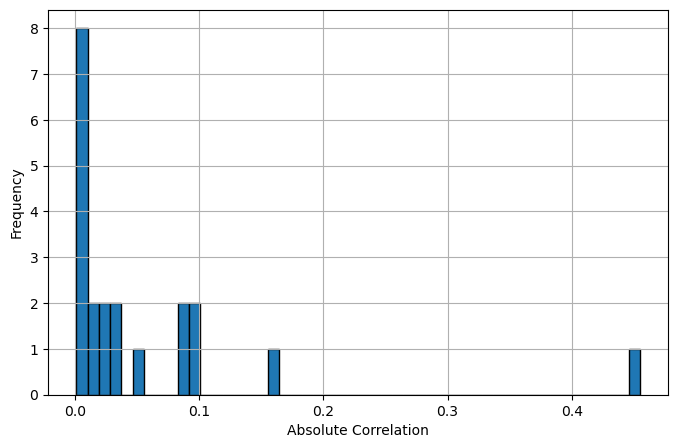

In [29]:
corr_vals.correlation.abs().hist(bins=50, figsize=(8, 5), edgecolor='black')
plt.xlabel("Absolute Correlation")
plt.ylabel("Frequency")

We do not observe high correlation between our input features. All the correlation below 0.5.

---

Let's perform stratified train_test_split

In [31]:
X = transformed_df.drop('y', axis=1).copy()
y = transformed_df['y'].copy()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

for label, target in zip(["Original", "Train", "Test"], [y, y_train, y_test]):
    proportions = target.value_counts(normalize=True)
    print(f"{label}")
    print(f"Proportion Not Subscribed: {proportions[0]} --- Proportion Subscribed: {proportions[1]} ")
    print("-"*100)

Original
Proportion Not Subscribed: 0.8830151954170445 --- Proportion Subscribed: 0.11698480458295547 
----------------------------------------------------------------------------------------------------
Train
Proportion Not Subscribed: 0.8830181375801813 --- Proportion Subscribed: 0.11698186241981863 
----------------------------------------------------------------------------------------------------
Test
Proportion Not Subscribed: 0.8830034280659074 --- Proportion Subscribed: 0.11699657193409267 
----------------------------------------------------------------------------------------------------


## Machine Learning 

Let's use separate preprocessing pipelines to handle different requirements for different classification models. 

* Logistic regression (and linear models in general) can suffer from perfect multicollinearity if we one-hot encode all categories and include an intercept and as such we need to drop one column from each one-hot encoded feature.
* Tree-based models (RandomForest, KNN, SVM, etc.) do not care about multicollinearity so it is safe to keep all one-hot encoded columns.

In [35]:
drop_cols = [
    'job_unknown', 'marital_divorced', 'education_unknown', 'default_no', 'housing_no', 'loan_no', 'contact_unknown', 'month_dec', 'poutcome_unknown'
]

logreg_preprocess = ColumnTransformer(
    transformers = [("drop", "drop", drop_cols)],
    remainder="passthrough"
)

# Let's create a function that return pipeline to perform ML for different models
def ml_pipeline(model, linear=False, scale=True):
    steps = []

    if linear:
        steps.append(("preprocess", logreg_preprocess))
        steps.append(("std_scaler", StandardScaler()))
    elif scale:
        steps.append(("std_scaler", StandardScaler()))

    steps.append(("model", model))
    
    return Pipeline(steps)

Let's define a utility function that return `python dict` with `accuracy`, `recall`, `precision` and `f1score`.

In [37]:
def evaluate_metrics(yt, yp):
    results_score = {}
    results_score['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f1_score, _ = precision_recall_fscore_support(yt, yp)
    results_score['recall'] = recall
    results_score['precision'] = precision
    results_score['f1_score'] = f1_score
    return results_score

Here we creater a helper function to plot confusion matrix for each model.

In [39]:
def confusion_matrix_plot(model_name, yt, yp):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(yt, yp)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix (Counts)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    plt.subplot(1, 2, 2)
    cmp = confusion_matrix(yt, yp, normalize='true')
    sns.heatmap(cmp, annot=True, fmt=".2f", cmap="Greens")
    plt.title("Confusion Matrix (Proportions)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    plt.suptitle(f"Confusion Matrix: {model_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
    plt.show()

#### Logistic Regression

Let's first tune hyperparameters for the Logistic Regression model to find the best parameters. Since our dataset is not balanced, we will strive to maximize the f1-score, or the auc (area-under-curve under the ROC).

In [41]:
lr = LogisticRegression(max_iter=1000)
lr_pipeline = ml_pipeline(model=lr, linear=True)

param_grid = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs', 'liblinear'],
    'model__class_weight': [None, 'balanced']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(lr_pipeline, param_grid=param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)

grid_search.fit(X_train, y_train)

,estimator,Pipeline(step..._iter=1000))])
,param_grid,"{'model__C': [0.01, 0.1, ...], 'model__class_weight': [None, 'balanced'], 'model__penalty': ['l2'], 'model__solver': ['lbfgs', 'liblinear']}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('drop', ...)]"


In [43]:
print("Best Params:", grid_search.best_params_)

Best Params: {'model__C': 0.01, 'model__class_weight': 'balanced', 'model__penalty': 'l2', 'model__solver': 'liblinear'}


In [45]:
y_pred = grid_search.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred), "\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8445206236868296 

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.85      0.91      7985
           1       0.42      0.82      0.55      1058

    accuracy                           0.84      9043
   macro avg       0.69      0.83      0.73      9043
weighted avg       0.91      0.84      0.86      9043



Based on the classification report, we can observe the following:

- Precision for class 1, is 0.42 which means only 42% of the customers predicted as “will subscribe” actually do. So there are some “false positives,” meaning we target some customers who won’t subscribe.
- Recall for class 1, is 0.82 which means we're catching 82% of actual potential subscribers. This maximize revenue.
- Precision for class 0 (customers who won't subscribe) is 0.97 meaning we have very low false positive for this class. Recall is 0.82 which means we are correctly identifying most of uninterested customers.

Generally speaking this is solid report, and wasting effort on 58% false positive is okay since the cost of contacting a customer is low when compared to losing potential customers.

Let's create dictionary that will store the best parameters for each model and evaluation metrics

In [47]:
models_info = {}

models_info['logistic_reg'] = {'best_paramets': grid_search.best_params_, 'evaluation_metrics': evaluate_metrics(y_test, y_pred)}

In [49]:
models_info['logistic_reg']['evaluation_metrics']

{'accuracy': 0.8445206236868296,
 'recall': array([0.84746399, 0.82230624]),
 'precision': array([0.97296909, 0.41666667]),
 'f1_score': array([0.90589023, 0.55308328])}

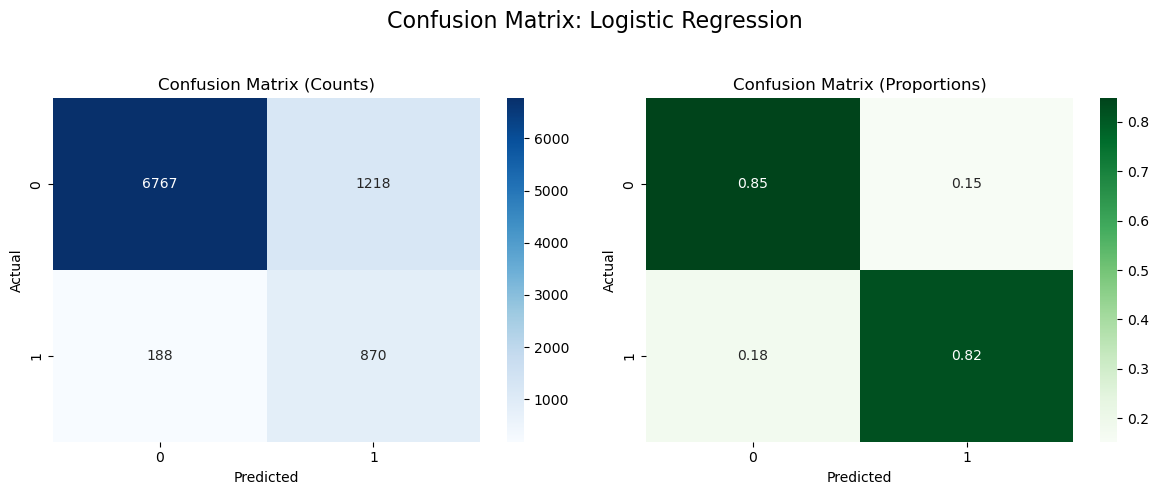

In [51]:
confusion_matrix_plot("Logistic Regression", y_test, y_pred)

---

#### K-Nearest Neighbors

Let's tune for the n-neighbors, weights and distance-metric.

In [53]:
knn = KNeighborsClassifier()

# we keep linear true to drop one column from each onehot encoded feature
# We will do that to avoid redundancy or bias in distance.
knn_pipeline = ml_pipeline(model=knn, linear=True) 

param_grid = {
    'model__n_neighbors': [k for k in range(1, 40, 2)],
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2]
}

grid_search_knn = GridSearchCV(knn_pipeline, param_grid=param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

,estimator,Pipeline(step...lassifier())])
,param_grid,"{'model__n_neighbors': [1, 3, ...], 'model__p': [1, 2], 'model__weights': ['uniform', 'distance']}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('drop', ...)]"


In [55]:
print("Best Params:", grid_search_knn.best_params_)

Best Params: {'model__n_neighbors': 39, 'model__p': 1, 'model__weights': 'distance'}


In [57]:
y_pred = grid_search_knn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred), "\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8946146190423532 

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94      7985
           1       0.70      0.17      0.28      1058

    accuracy                           0.89      9043
   macro avg       0.80      0.58      0.61      9043
weighted avg       0.88      0.89      0.87      9043



We can observe the following from the classification report:

- KNN is heavily biased toward the majority class (uninterested customers). Almost all non-subscribers are classified correctly.
- KNN precision is high (70% )relative to Logistic Regression (42%) but it only identify 70% of subscribed customers.
- F1-score is poor (0.28).

Business wise, the KNN model is very poor. 

In [59]:
models_info['knn'] = {'best_paramets': grid_search_knn.best_params_, 'evaluation_metrics': evaluate_metrics(y_test, y_pred)}

In [61]:
models_info['knn']['evaluation_metrics']

{'accuracy': 0.8946146190423532,
 'recall': array([0.99048215, 0.1710775 ]),
 'precision': array([0.90018211, 0.70428016]),
 'f1_score': array([0.94317572, 0.27528517])}

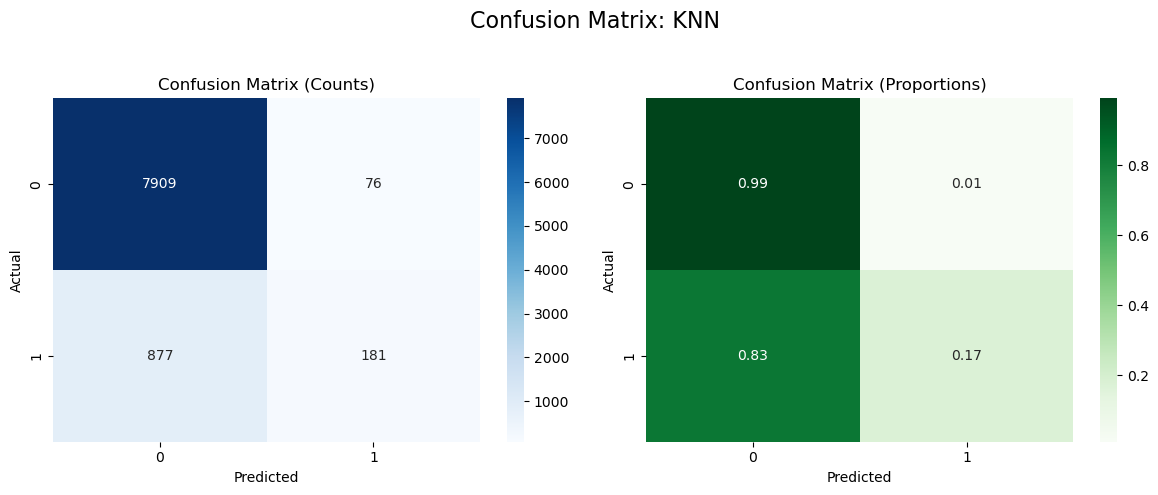

In [63]:
confusion_matrix_plot("KNN", y_test, y_pred)

---

## Support Vector Machine

Let's use linear SVM model here.

In [65]:
lsvc = LinearSVC(max_iter=5000)

lsvc_pipeline = ml_pipeline(model=lsvc, linear=True) 

param_grid = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__class_weight': [None, 'balanced']
}

grid_search_lsvc = GridSearchCV(lsvc_pipeline, param_grid=param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
grid_search_lsvc.fit(X_train, y_train)

,estimator,Pipeline(step..._iter=5000))])
,param_grid,"{'model__C': [0.01, 0.1, ...], 'model__class_weight': [None, 'balanced']}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('drop', ...)]"


In [67]:
print("Best Params:", grid_search_lsvc.best_params_)

Best Params: {'model__C': 0.01, 'model__class_weight': 'balanced'}


In [69]:
y_pred = grid_search_lsvc.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred), "\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8501603450182461 

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.86      0.91      7985
           1       0.43      0.81      0.56      1058

    accuracy                           0.85      9043
   macro avg       0.70      0.83      0.73      9043
weighted avg       0.91      0.85      0.87      9043



The result of this classification report is similar to that of logistic regression.

In [71]:
models_info['linear_svc'] = {'best_paramets': grid_search_lsvc.best_params_, 'evaluation_metrics': evaluate_metrics(y_test, y_pred)}

In [73]:
models_info['linear_svc']['evaluation_metrics']

{'accuracy': 0.8501603450182461,
 'recall': array([0.85585473, 0.80718336]),
 'precision': array([0.97101449, 0.42593516]),
 'f1_score': array([0.90980497, 0.55762325])}

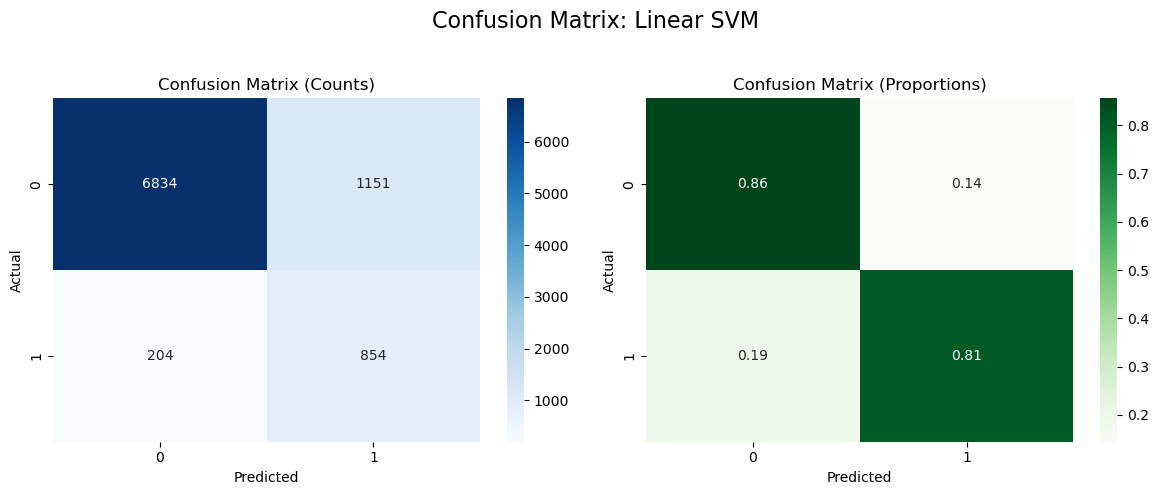

In [75]:
confusion_matrix_plot("Linear SVM", y_test, y_pred)

---

## Random Forest

In [77]:
rf = RandomForestClassifier()

# rf does not need scaling or drop one colum from each one hot-encoded feature
rf_pipeline = ml_pipeline(model=rf, scale=False) 

param_grid = {
    'model__n_estimators': [50, 100, 200, 400],
    'model__max_depth': [10, 20],
    'model__max_features': ['sqrt', 'log2'],
    'model__min_samples_split': [10],
    'model__min_samples_leaf': [5],
    'model__class_weight': [None, 'balanced']
}

grid_search_rf = GridSearchCV(rf_pipeline, param_grid=param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

,estimator,Pipeline(step...lassifier())])
,param_grid,"{'model__class_weight': [None, 'balanced'], 'model__max_depth': [10, 20], 'model__max_features': ['sqrt', 'log2'], 'model__min_samples_leaf': [5], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,400


In [79]:
print("Best Params:", grid_search_rf.best_params_)

Best Params: {'model__class_weight': None, 'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 10, 'model__n_estimators': 400}


In [81]:
y_pred = grid_search_rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred), "\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9058940617051864 

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      7985
           1       0.70      0.34      0.46      1058

    accuracy                           0.91      9043
   macro avg       0.81      0.66      0.70      9043
weighted avg       0.89      0.91      0.89      9043



From the classification report, we can be observe that RF outperforms KNN but falls short of the performance of linear models (Logistic Reg and SVM).

In [83]:
models_info['random_forest'] = {'best_paramets': grid_search_rf.best_params_, 'evaluation_metrics': evaluate_metrics(y_test, y_pred)}

In [85]:
models_info['random_forest']['evaluation_metrics']

{'accuracy': 0.9058940617051864,
 'recall': array([0.98071384, 0.34120983]),
 'precision': array([0.91826923, 0.70097087]),
 'f1_score': array([0.94846485, 0.45899555])}

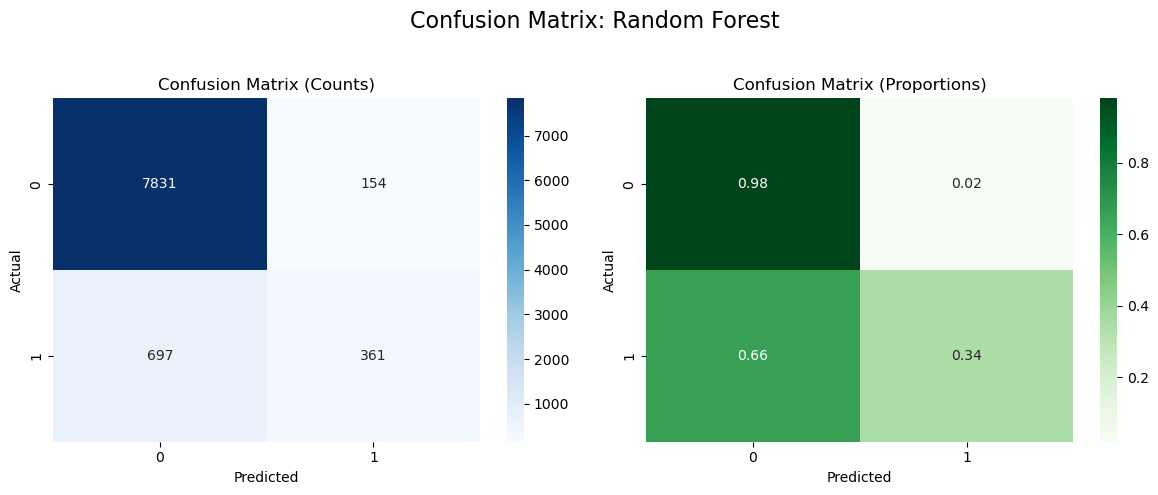

In [87]:
confusion_matrix_plot("Random Forest", y_test, y_pred)

#### Comparing Models

Let's compare our results for the models tested.

In [89]:
# Add model name to the evaluation dict
models_info['logistic_reg']['evaluation_metrics']['model_name'] = "Logistic Regression"
models_info['knn']['evaluation_metrics']['model_name'] = "KNN"
models_info['linear_svc']['evaluation_metrics']['model_name'] = "Support Vector Machine (Linear)"
models_info['random_forest']['evaluation_metrics']['model_name'] = "Random Forest"

evaluation_list = []
for key in models_info.keys():
    evaluation_list.append(models_info[key]['evaluation_metrics'])

eval_df = pd.DataFrame(evaluation_list)
eval_df[["recall_unsubscribed", "recall_subscribed"]] = eval_df['recall'].apply(pd.Series)
eval_df[["precision_unsubscribed", "precision_subscribed"]] = eval_df['precision'].apply(pd.Series)
eval_df[["f1_score_unsubscribed", "f1_score_subscribed"]] = eval_df['f1_score'].apply(pd.Series)
eval_df = eval_df.drop(['recall', 'precision', 'f1_score'], axis=1)

eval_df.drop(['recall_unsubscribed', 'precision_unsubscribed', 'f1_score_unsubscribed'], axis=1).head()

,accuracy,model_name,recall_subscribed,precision_subscribed,f1_score_subscribed
0,0.844521,Logistic Regression,0.822306,0.416667,0.553083
1,0.894615,KNN,0.171078,0.704280,0.275285
2,0.850160,Support Vector Machine (Linear),0.807183,0.425935,0.557623
3,0.905894,Random Forest,0.341210,0.700971,0.458996


We will proceed with Logistic Regression due to its interpretability.

In [92]:
log_reg_pipe = grid_search.best_estimator_
log_reg_pipe

,steps,"[('preprocess', ...), ('std_scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('drop', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


---

## Feature Importance

In [94]:
log_reg = log_reg_pipe.named_steps["model"]
log_reg

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.01
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [98]:
coefficients = log_reg.coef_[0]

feature_importance = pd.DataFrame({
    "Feature": X.drop(drop_cols, axis=1).columns,
    "Coefficients": coefficients,
    "Absolute Coefficients": np.abs(coefficients)
}).sort_values(by="Absolute Coefficients", ascending=False)

feature_importance.head(10)

,Feature,Coefficients,Absolute Coefficients
3,duration,1.448642,1.448642
26,contact_cellular,0.697000,0.697000
41,poutcome_success,0.456015,0.456015
24,housing_yes,-0.369765,0.369765
27,contact_telephone,0.356133,0.356133
32,month_jul,-0.345757,0.345757
35,month_may,-0.304797,0.304797
29,month_aug,-0.282995,0.282995
4,campaign,-0.255050,0.255050
36,month_nov,-0.248390,0.248390


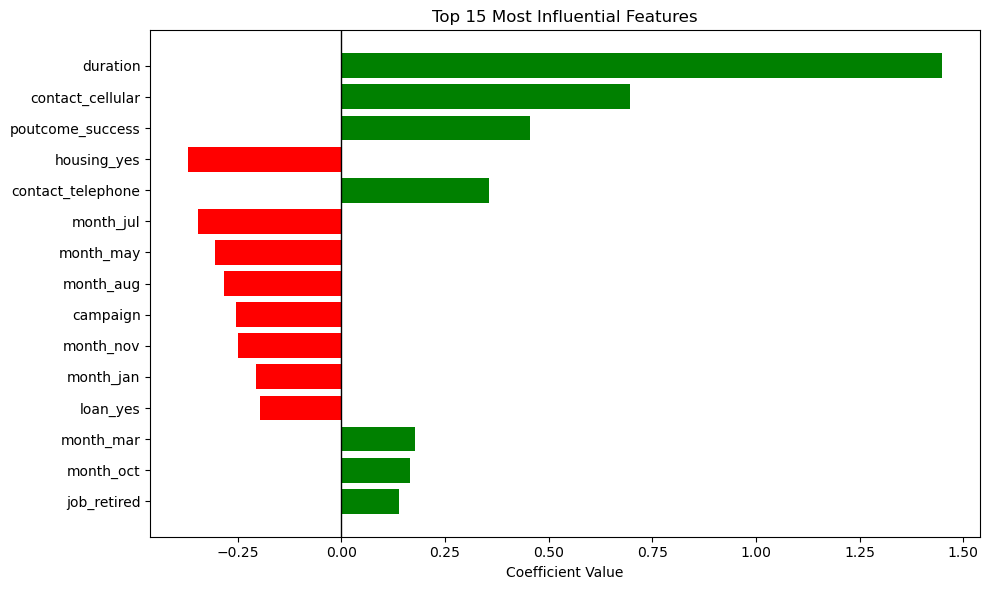

In [100]:
plt.figure(figsize=(10, 6))

colors = np.where(feature_importance["Coefficients"] > 0, "green", "red")

plt.barh(feature_importance["Feature"][:15], feature_importance["Coefficients"][:15], color=colors)
plt.gca().invert_yaxis()
plt.xlabel("Coefficient Value")
plt.axvline(0, color="black", linewidth=1)
plt.title("Top 15 Most Influential Features")
plt.tight_layout()
plt.show()

Based on the feature importance plot:

- Longer call duration strongly increase the likelihood of a successful subscription.
- Contacting the client via cellular communication has a strong association with a positive outcome.
- poutcome_success, is a strong an indicator that client will subscribe given that he/she previously responded positively.
- Customers with housing or personal loans are less likely to subscribe.
- We observe a seasonal effect with contacts made in March and October having a higher likelihood of success.
- January, May, July, August and November are associated with negative effect on the probability of a client subscribing.
- Retired clients are more receptive to a new term deposit.